# Final Individual Recommender System

# Importing the Datasets

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Make Pandas Display all columns
pd.set_option('display.max_columns', None)

In [3]:
# Load the ratings data
ratings_df_slim = pd.read_csv('../dataset/XWines_Slim_150K_ratings.csv')
ratings_df_full = pd.read_csv('../dataset/XWines_Full_21M_ratings.csv')

# Load the wines data
wines_df_slim = pd.read_csv('../dataset/XWines_Slim_1K_wines.csv')
wines_df_full = pd.read_csv('../dataset/XWines_Full_100K_wines.csv')


/var/folders/9n/hfw66rw97sl45x98mmd_vs4r0000gn/T/ipykernel_57516/1459283311.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings_df_slim = pd.read_csv('../dataset/XWines_Slim_150K_ratings.csv')
/var/folders/9n/hfw66rw97sl45x98mmd_vs4r0000gn/T/ipykernel_57516/1459283311.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings_df_full = pd.read_csv('../dataset/XWines_Full_21M_ratings.csv')


# Data Pre-Processing

In [4]:
# Dropping some of the Columns in the wines_df
# Some are irrelevant for analysis (like the website) and some will just be repeated info (like the Code and Country)
wine_columns_to_drop_repeated = ['Website', 'Code', 'RegionID', 'WineryID', 'WineName', 'RegionName', 'WineryName']
wines_df_slim.drop(columns=wine_columns_to_drop_repeated, inplace=True)
wines_df_full.drop(columns=wine_columns_to_drop_repeated, inplace=True)

In [5]:
# Dropping the Features we will not use for ML due to the extremely high dimensionality
wine_columns_to_drop_high_dimensionality = ['Grapes'] # Too many unique values
wines_df_slim.drop(columns=wine_columns_to_drop_high_dimensionality, inplace=True)
wines_df_full.drop(columns=wine_columns_to_drop_high_dimensionality, inplace=True)

In [6]:
# Convert string to list
import ast

wines_df_slim['Harmonize'] = wines_df_slim['Harmonize'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
wines_df_slim['Vintages'] = wines_df_slim['Vintages'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
wines_df_slim['Vintages'] = wines_df_slim['Vintages'].apply(lambda x: [int(v) for v in ast.literal_eval(x)] if isinstance(x, str) else x)

wines_df_full['Harmonize'] = wines_df_full['Harmonize'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
wines_df_full['Vintages'] = wines_df_full['Vintages'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
wines_df_full['Vintages'] = wines_df_full['Vintages'].apply(lambda x: [int(v) for v in ast.literal_eval(x)] if isinstance(x, str) else x)

In [7]:
# Processing Vintages
def process_vintages(vintages):
    # Remove "N.V." from the list
    filtered_vintages = [vintage for vintage in vintages if vintage != "N.V."]

    # Calculate the number of vintages
    num_vintages = len(filtered_vintages)

    # Find the oldest and most recent vintages
    oldest_vintage = min(filtered_vintages) if filtered_vintages else 0
    most_recent_vintage = max(filtered_vintages) if filtered_vintages else 0
    vintage_range = most_recent_vintage - oldest_vintage

    return num_vintages, oldest_vintage, most_recent_vintage, vintage_range

# Apply the function to each row for both dataset versions
wines_df_slim[['num_vintages', 'oldest_vintage', 'most_recent_vintage', 'vintage_range']] = wines_df_slim['Vintages'].apply(process_vintages).tolist()
wines_df_full[['num_vintages', 'oldest_vintage', 'most_recent_vintage', 'vintage_range']] = wines_df_full['Vintages'].apply(process_vintages).tolist()

In [8]:
# Drop the original Vintages column for both datasets, since we susbtituted with the new columns 
wines_df_slim.drop(columns=['Vintages'], inplace=True)
wines_df_full.drop(columns=['Vintages'], inplace=True)

In [9]:
#some renaming if we want to use the lenskit later:
ratings_df_slim = ratings_df_slim.rename(columns={'UserID': 'user', 'WineID': 'item', 'Rating': 'rating', 'Date': 'timestamp'})
ratings_df_full = ratings_df_full.rename(columns={'UserID': 'user', 'WineID': 'item', 'Rating': 'rating', 'Date': 'timestamp'})


wines_df_slim = wines_df_slim.rename(columns={'WineID': 'item'})
wines_df_full = wines_df_full.rename(columns={'WineID': 'item'})

In [10]:
# Explode 'Harmonize' column into individual rows
wines_exploded_slim = wines_df_slim.explode('Harmonize')
wines_exploded_full = wines_df_full.explode('Harmonize')

# One-hot encode the 'Harmonize' column with the desired prefix
harmonize_one_hot_slim = pd.get_dummies(wines_exploded_slim['Harmonize'], prefix='harmonize_with')
harmonize_one_hot_full = pd.get_dummies(wines_exploded_full['Harmonize'], prefix='harmonize_with')

# Group by 'item' and sum to combine back into single rows per item
harmonize_one_hot_grouped_slim = harmonize_one_hot_slim.groupby(wines_exploded_slim['item']).sum()
harmonize_one_hot_grouped_full = harmonize_one_hot_full.groupby(wines_exploded_full['item']).sum()

# Merge the one-hot encodings with the original DataFrame
wines_df_slim = wines_df_slim.merge(harmonize_one_hot_grouped_slim, left_on='item', right_index=True, how='left')
wines_df_full = wines_df_full.merge(harmonize_one_hot_grouped_full, left_on='item', right_index=True, how='left')

In [11]:
# Drop the Harmonize Column on both versions for the wines
wines_df_slim.drop(columns=['Harmonize'], inplace=True)
wines_df_full.drop(columns=['Harmonize'], inplace=True)

In [12]:
# Re-apply One-Hot Encoding with dtype=int for wines_df_slim
wines_df_slim = pd.get_dummies(
    wines_df_slim,
    columns=['Type', 'Elaborate', 'Body', 'Acidity', 'Country'],
    dtype=int
)

# Re-apply One-Hot Encoding with dtype=int for wines_df_full
wines_df_full = pd.get_dummies(
    wines_df_full,
    columns=['Type', 'Elaborate', 'Body', 'Acidity', 'Country'],
    dtype=int
)

In [13]:
''' NOT NEEDED FOR DECISION TREE
# Scale the Numerical Features
numerical_features_to_scale = ['ABV', 'num_vintages', 'oldest_vintage', 'most_recent_vintage', 'vintage_range']

# Scale the numerical features for both datasets
from sklearn.preprocessing import StandardScaler

scaler_for_slim = StandardScaler()
wines_df_slim[numerical_features_to_scale] = scaler_for_slim.fit_transform(wines_df_slim[numerical_features_to_scale])

scaler_for_full = StandardScaler()
wines_df_full[numerical_features_to_scale] = scaler_for_full.fit_transform(wines_df_full[numerical_features_to_scale])
'''


" NOT NEEDED FOR DECISION TREE\n# Scale the Numerical Features\nnumerical_features_to_scale = ['ABV', 'num_vintages', 'oldest_vintage', 'most_recent_vintage', 'vintage_range']\n\n# Scale the numerical features for both datasets\nfrom sklearn.preprocessing import StandardScaler\n\nscaler_for_slim = StandardScaler()\nwines_df_slim[numerical_features_to_scale] = scaler_for_slim.fit_transform(wines_df_slim[numerical_features_to_scale])\n\nscaler_for_full = StandardScaler()\nwines_df_full[numerical_features_to_scale] = scaler_for_full.fit_transform(wines_df_full[numerical_features_to_scale])\n"

## Create the Mask for the Ratings
* 1 - 3.5 - 0
* 4 - 4.5 - 1
* 4.5 - 5 - 2

In [14]:
# Go through the Ratings on both datasets and subsitute the values based on conditions - As discussed with Francesco and Nava, it would be better to treat the propblem as 3 Class 
# Instead of treating it as a 9 Class Classification Problem
def label_rating(rating):
    if rating <= 3.5: #~41%
        return 0
    elif rating == 4.0: #~36%
        return 1
    elif 4.5 <= rating <= 5.0: #~22%
        return 2

# Apply the function to create the new column 'rating_label'
ratings_df_slim['rating_label'] = ratings_df_slim['rating'].apply(label_rating)
ratings_df_full['rating_label'] = ratings_df_full['rating'].apply(label_rating)

In [15]:
# Dropping the Unecessary Columns for ratings 
ratings_df_slim.drop(columns=['timestamp', 'Vintage', 'rating'], inplace=True) # The Rating Label substitutes the rating column 

In [16]:
# How the Wines Dataset looks like after all Preprocessing
display(wines_df_slim.head())

,item,ABV,num_vintages,oldest_vintage,most_recent_vintage,vintage_range,harmonize_with_Aperitif,harmonize_with_Appetizer,harmonize_with_Barbecue,harmonize_with_Beef,harmonize_with_Blue Cheese,harmonize_with_Cake,harmonize_with_Cheese,harmonize_with_Chicken,harmonize_with_Chocolate,harmonize_with_Codfish,harmonize_with_Cold Cuts,harmonize_with_Cream,harmonize_with_Cured Meat,harmonize_with_Dessert,harmonize_with_Duck,harmonize_with_Fish,harmonize_with_French Fries,harmonize_with_Fruit,harmonize_with_Fruit Dessert,harmonize_with_Game Meat,harmonize_with_Goat Cheese,harmonize_with_Grilled,harmonize_with_Ham,harmonize_with_Hard Cheese,harmonize_with_Lamb,harmonize_with_Lean Fish,harmonize_with_Light Stews,harmonize_with_Maturated Cheese,harmonize_with_Mushrooms,harmonize_with_Pasta,harmonize_with_Pizza,harmonize_with_Pork,harmonize_with_Poultry,harmonize_with_Rich Fish,harmonize_with_Risotto,harmonize_with_Salad,harmonize_with_Seafood,harmonize_with_Shellfish,harmonize_with_Snack,harmonize_with_Soft Cheese,harmonize_with_Soufflé,harmonize_with_Spicy Food,harmonize_with_Sweet Dessert,harmonize_with_Tomato Dishes,harmonize_with_Veal,harmonize_with_Vegetarian,Type_Dessert,Type_Dessert/Port,Type_Red,Type_Rosé,Type_Sparkling,Type_White,Elaborate_Assemblage/Blend,Elaborate_Assemblage/Bordeaux Red Blend,Elaborate_Assemblage/Champagne Blend,Elaborate_Assemblage/Port Blend,Elaborate_Assemblage/Portuguese Red Blend,Elaborate_Assemblage/Portuguese White Blend,Elaborate_Assemblage/Priorat Red Blend,Elaborate_Assemblage/Provence Rosé Blend,Elaborate_Assemblage/Rhône Red Blend,Elaborate_Assemblage/Tuscan Red Blend,Elaborate_Assemblage/Valpolicella Red Blend,Elaborate_Varietal/100%,Elaborate_Varietal/>75%,Body_Full-bodied,Body_Light-bodied,Body_Medium-bodied,Body_Very full-bodied,Body_Very light-bodied,Acidity_High,Acidity_Low,Acidity_Medium,Country_Argentina,Country_Australia,Country_Austria,Country_Brazil,Country_Canada,Country_Chile,Country_Croatia,Country_Czech Republic,Country_France,Country_Germany,Country_Greece,Country_Hungary,Country_Israel,Country_Italy,Country_Lebanon,Country_Malta,Country_Mexico,Country_Moldova,Country_New Zealand,Country_Portugal,Country_Romania,Country_Russia,Country_Slovenia,Country_South Africa,Country_Spain,Country_Switzerland,Country_Turkey,Country_Ukraine,Country_United Kingdom,Country_United States,Country_Uruguay
0,100001,7.5,36,1966,2020,54,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,100002,12.0,13,2001,2016,15,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,100003,12.0,23,1960,2021,61,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,100005,11.0,24,1970,2021,51,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,100007,7.5,14,1981,2018,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
# How the Ratings Dataset looks like after all Preprocessing
display(ratings_df_slim.head())

,RatingID,user,item,rating_label
0,143,1356810,103471,2
1,199,1173759,111415,2
2,348,1164877,111395,2
3,374,1207665,111433,2
4,834,1075841,111431,2


# Content Based Classifier - Decision Tree - SLIM

In [18]:
# Define the user ID
user_id = 1356810

# Extract user_ratings: only the ratings provided by user 1356810
user_ratings = ratings_df_slim[ratings_df_slim['user'] == user_id]

# Display user_ratings
print("User Ratings:")
display(user_ratings)


User Ratings:


,RatingID,user,item,rating_label
0,143,1356810,103471,2
2392,106754,1356810,111544,2
4083,189235,1356810,112084,2
6213,303219,1356810,111461,2
10006,566593,1356810,193478,1
11483,680472,1356810,111927,2
14652,972573,1356810,111484,0
14738,981402,1356810,113332,1
19543,1587778,1356810,111521,1
20389,1715707,1356810,141805,1


In [19]:
# Extract user_wines: only the wines that user 1356810 has rated
user_wines = wines_df_slim[wines_df_slim['item'].isin(user_ratings['item'])]

# Display user_wines
print("\nUser Wines:")
display(user_wines)



User Wines:


,item,ABV,num_vintages,oldest_vintage,most_recent_vintage,vintage_range,harmonize_with_Aperitif,harmonize_with_Appetizer,harmonize_with_Barbecue,harmonize_with_Beef,harmonize_with_Blue Cheese,harmonize_with_Cake,harmonize_with_Cheese,harmonize_with_Chicken,harmonize_with_Chocolate,harmonize_with_Codfish,harmonize_with_Cold Cuts,harmonize_with_Cream,harmonize_with_Cured Meat,harmonize_with_Dessert,harmonize_with_Duck,harmonize_with_Fish,harmonize_with_French Fries,harmonize_with_Fruit,harmonize_with_Fruit Dessert,harmonize_with_Game Meat,harmonize_with_Goat Cheese,harmonize_with_Grilled,harmonize_with_Ham,harmonize_with_Hard Cheese,harmonize_with_Lamb,harmonize_with_Lean Fish,harmonize_with_Light Stews,harmonize_with_Maturated Cheese,harmonize_with_Mushrooms,harmonize_with_Pasta,harmonize_with_Pizza,harmonize_with_Pork,harmonize_with_Poultry,harmonize_with_Rich Fish,harmonize_with_Risotto,harmonize_with_Salad,harmonize_with_Seafood,harmonize_with_Shellfish,harmonize_with_Snack,harmonize_with_Soft Cheese,harmonize_with_Soufflé,harmonize_with_Spicy Food,harmonize_with_Sweet Dessert,harmonize_with_Tomato Dishes,harmonize_with_Veal,harmonize_with_Vegetarian,Type_Dessert,Type_Dessert/Port,Type_Red,Type_Rosé,Type_Sparkling,Type_White,Elaborate_Assemblage/Blend,Elaborate_Assemblage/Bordeaux Red Blend,Elaborate_Assemblage/Champagne Blend,Elaborate_Assemblage/Port Blend,Elaborate_Assemblage/Portuguese Red Blend,Elaborate_Assemblage/Portuguese White Blend,Elaborate_Assemblage/Priorat Red Blend,Elaborate_Assemblage/Provence Rosé Blend,Elaborate_Assemblage/Rhône Red Blend,Elaborate_Assemblage/Tuscan Red Blend,Elaborate_Assemblage/Valpolicella Red Blend,Elaborate_Varietal/100%,Elaborate_Varietal/>75%,Body_Full-bodied,Body_Light-bodied,Body_Medium-bodied,Body_Very full-bodied,Body_Very light-bodied,Acidity_High,Acidity_Low,Acidity_Medium,Country_Argentina,Country_Australia,Country_Austria,Country_Brazil,Country_Canada,Country_Chile,Country_Croatia,Country_Czech Republic,Country_France,Country_Germany,Country_Greece,Country_Hungary,Country_Israel,Country_Italy,Country_Lebanon,Country_Malta,Country_Mexico,Country_Moldova,Country_New Zealand,Country_Portugal,Country_Romania,Country_Russia,Country_Slovenia,Country_South Africa,Country_Spain,Country_Switzerland,Country_Turkey,Country_Ukraine,Country_United Kingdom,Country_United States,Country_Uruguay
54,101566,13.5,41,1966,2021,55,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
98,103471,20.0,54,1950,2021,71,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
204,111461,12.0,69,1950,2020,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
206,111468,12.5,65,1951,2021,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
211,111484,12.5,68,1952,2021,69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
215,111521,12.5,69,1950,2021,71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
218,111544,12.5,70,1950,2021,71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,

In [20]:
# Merge user_ratings with user_wines on 'item'
merged_data = pd.merge(user_ratings, user_wines, on='item', how='inner')

# Display merged_data
print("\nMerged Data:")
display(merged_data)



Merged Data:


,RatingID,user,item,rating_label,ABV,num_vintages,oldest_vintage,most_recent_vintage,vintage_range,harmonize_with_Aperitif,harmonize_with_Appetizer,harmonize_with_Barbecue,harmonize_with_Beef,harmonize_with_Blue Cheese,harmonize_with_Cake,harmonize_with_Cheese,harmonize_with_Chicken,harmonize_with_Chocolate,harmonize_with_Codfish,harmonize_with_Cold Cuts,harmonize_with_Cream,harmonize_with_Cured Meat,harmonize_with_Dessert,harmonize_with_Duck,harmonize_with_Fish,harmonize_with_French Fries,harmonize_with_Fruit,harmonize_with_Fruit Dessert,harmonize_with_Game Meat,harmonize_with_Goat Cheese,harmonize_with_Grilled,harmonize_with_Ham,harmonize_with_Hard Cheese,harmonize_with_Lamb,harmonize_with_Lean Fish,harmonize_with_Light Stews,harmonize_with_Maturated Cheese,harmonize_with_Mushrooms,harmonize_with_Pasta,harmonize_with_Pizza,harmonize_with_Pork,harmonize_with_Poultry,harmonize_with_Rich Fish,harmonize_with_Risotto,harmonize_with_Salad,harmonize_with_Seafood,harmonize_with_Shellfish,harmonize_with_Snack,harmonize_with_Soft Cheese,harmonize_with_Soufflé,harmonize_with_Spicy Food,harmonize_with_Sweet Dessert,harmonize_with_Tomato Dishes,harmonize_with_Veal,harmonize_with_Vegetarian,Type_Dessert,Type_Dessert/Port,Type_Red,Type_Rosé,Type_Sparkling,Type_White,Elaborate_Assemblage/Blend,Elaborate_Assemblage/Bordeaux Red Blend,Elaborate_Assemblage/Champagne Blend,Elaborate_Assemblage/Port Blend,Elaborate_Assemblage/Portuguese Red Blend,Elaborate_Assemblage/Portuguese White Blend,Elaborate_Assemblage/Priorat Red Blend,Elaborate_Assemblage/Provence Rosé Blend,Elaborate_Assemblage/Rhône Red Blend,Elaborate_Assemblage/Tuscan Red Blend,Elaborate_Assemblage/Valpolicella Red Blend,Elaborate_Varietal/100%,Elaborate_Varietal/>75%,Body_Full-bodied,Body_Light-bodied,Body_Medium-bodied,Body_Very full-bodied,Body_Very light-bodied,Acidity_High,Acidity_Low,Acidity_Medium,Country_Argentina,Country_Australia,Country_Austria,Country_Brazil,Country_Canada,Country_Chile,Country_Croatia,Country_Czech Republic,Country_France,Country_Germany,Country_Greece,Country_Hungary,Country_Israel,Country_Italy,Country_Lebanon,Country_Malta,Country_Mexico,Country_Moldova,Country_New Zealand,Country_Portugal,Country_Romania,Country_Russia,Country_Slovenia,Country_South Africa,Country_Spain,Country_Switzerland,Country_Turkey,Country_Ukraine,Country_United Kingdom,Country_United States,Country_Uruguay
0,143,1356810,103471,2,20.0,54,1950,2021,71,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,106754,1356810,111544,2,12.5,70,1950,2021,71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,189235,1356810,112084,2,12.5,72,1950,2021,71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,303219,1356810,111461,2,12.0,69,1950,2020,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,566593,1356810,193478,1,14.0,61,1956,2021,65,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,680472,1356810,111927,2,12.0,62,1951,2021,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,972573,1356810,111484,0,12.5,68,1952,2021,69,0,0,0,0,0,0,0,0,0,0,0,0,0

In [21]:
# Define the minimum number of ratings required
MIN_RATINGS = 5

# Calculate the original number of unique users
original_user_count = ratings_df_slim['user'].nunique()
print(f"Original number of users: {original_user_count}")

# Filter out users with fewer than MIN_RATINGS by reassigning back to ratings_df_slim
ratings_df_slim = ratings_df_slim.groupby('user').filter(lambda x: len(x) >= MIN_RATINGS)

# Calculate the number of unique users after filtering
filtered_user_count = ratings_df_slim['user'].nunique()
print(f"Number of users after filtering: {filtered_user_count}")

# Optional: Calculate the number of users removed
removed_user_count = original_user_count - filtered_user_count
print(f"Number of users removed: {removed_user_count}")


Original number of users: 10561
Number of users after filtering: 10254
Number of users removed: 307


In [22]:
# Here, we train one Decision Tree Classifier per user (Content Based Filtering)
# We split the User Ratings into Training and Testing Data (80-20 Stratified Split, with fallback to regular split)

# IMPORTS
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd  # Ensure pandas is imported
import numpy as np   # Ensure numpy is imported

# Initialize a dictionary to store user models and their evaluation metrics
user_models = {}

# Initialize an array to store user IDs where stratified split failed
failed_strat_users = []  # Normal Split will be used for these users

# Go through all the users
for user in ratings_df_slim['user'].unique():
    
    # Get all the ratings for the current user
    user_ratings = ratings_df_slim[ratings_df_slim['user'] == user]
    
    # Get the Subset of the Wines Dataset that the user has rated
    user_wines = wines_df_slim[wines_df_slim['item'].isin(user_ratings['item'])]

    # Merge user_ratings with user_wines on the 'item' column
    merged_data = pd.merge(user_ratings, user_wines, on='item', how='inner')
    
    # Specify which features we are NOT gonna use in X
    features_to_drop_for_X = ['RatingID', 'user', 'item', 'rating_label']
    
    # Ensure that the columns to drop exist in merged_data to prevent KeyError
    existing_features_to_drop = [col for col in features_to_drop_for_X if col in merged_data.columns]
    
    # Get X and y
    X = merged_data.drop(columns=existing_features_to_drop)
    y = merged_data['rating_label']

    # Convert all features to numeric, coercing errors and filling NaNs with 0
    # Uncomment the following line if your features are not already numeric
    # X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # Attempt to split the data into training and testing sets with stratification
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )
    except ValueError as e:
        # Stratified split failed; fallback to regular split
        # Instead of printing, append the user ID to failed_strat_users
        failed_strat_users.append(user)  
        
        # Perform a regular split without stratification
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
    
    # Create the Decision Tree Classifier
    clf = DecisionTreeClassifier(max_depth=3, random_state=42)  # Added random_state for reproducibility
    
    # Fit the model
    clf.fit(X_train, y_train)
    
    # Make predictions on the training set
    y_train_pred = clf.predict(X_train)
    
    # Make predictions on the test set
    y_test_pred = clf.predict(X_test)
    
    # Evaluate the model on the training set
    train_accuracy = float(clf.score(X_train, y_train))  # Ensure float
    train_precision = float(precision_score(y_train, y_train_pred, average='macro', zero_division=0))  # Ensure float
    train_recall = float(recall_score(y_train, y_train_pred, average='macro', zero_division=0))        # Ensure float
    train_f1 = float(f1_score(y_train, y_train_pred, average='macro', zero_division=0))                # Ensure float
    train_conf_matrix = confusion_matrix(y_train, y_train_pred).tolist()  # Convert to list for JSON compatibility
    
    # Evaluate the model on the test set
    test_accuracy = float(clf.score(X_test, y_test))    # Ensure float
    test_precision = float(precision_score(y_test, y_test_pred, average='macro', zero_division=0))  # Ensure float
    test_recall = float(recall_score(y_test, y_test_pred, average='macro', zero_division=0))        # Ensure float
    test_f1 = float(f1_score(y_test, y_test_pred, average='macro', zero_division=0))                # Ensure float
    test_conf_matrix = confusion_matrix(y_test, y_test_pred).tolist()  # Convert to list for JSON compatibility
    
    # Store metrics and model in user_models
    user_models[user] = {
        'model': clf,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_precision': train_precision,
        'test_precision': test_precision,
        'train_recall': train_recall,
        'test_recall': test_recall,
        'train_f1_score': train_f1,
        'test_f1_score': test_f1,
        'train_confusion_matrix': train_conf_matrix,
        'test_confusion_matrix': test_conf_matrix
    }

# After processing all users, you can inspect the failed_strat_users array
# For example, to see how many users had failed stratified splits:
print(f"Number of users with failed stratified splits: {len(failed_strat_users)}")

# Optionally, to view the list of these user IDs:
# print("Users with failed stratified splits:", failed_strat_users)


/Users/joaovictor/anaconda3/envs/recsys/lib/python3.11/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/joaovictor/anaconda3/envs/recsys/lib/python3.11/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/joaovictor/anaconda3/envs/recsys/lib/python3.11/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/joaovictor/anaconda3/envs/recsys/lib/python3.11/site-packages/sklearn/metrics/_classification.py:409: UserWa

Number of users with failed stratified splits: 3974


In [23]:
# Convert the user_models dictionary to a DataFrame
metrics_df = pd.DataFrame(user_models).T  # Transpose to have users as rows

# Display the first few rows to verify
display(metrics_df.head())


,model,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1_score,test_f1_score,train_confusion_matrix,test_confusion_matrix
1356810,"DecisionTreeClassifier(max_depth=3, random_sta...",0.8125,0.25,0.847222,0.166667,0.791667,0.333333,0.780556,0.222222,"[[4, 0, 0], [1, 7, 0], [1, 1, 2]]","[[0, 1, 0], [1, 0, 1], [0, 0, 1]]"
1173759,"DecisionTreeClassifier(max_depth=3, random_sta...",0.8,0.5,0.888889,0.444444,0.790476,0.5,0.805387,0.466667,"[[4, 1, 0], [0, 8, 0], [0, 3, 4]]","[[2, 0, 0], [0, 1, 1], [0, 2, 0]]"
1164877,"DecisionTreeClassifier(max_depth=3, random_sta...",0.8,0.6,0.583333,0.2,0.6,0.333333,0.582011,0.25,"[[12, 0, 0], [1, 4, 0], [3, 0, 0]]","[[3, 0, 0], [1, 0, 0], [1, 0, 0]]"
1207665,"DecisionTreeClassifier(max_depth=3, random_sta...",0.875,0.5,0.933333,0.25,0.888889,0.5,0.896296,0.333333,"[[2, 0, 1], [0, 1, 0], [0, 0, 4]]","[[0, 1], [0, 1]]"
1075841,"DecisionTreeClassifier(max_depth=3, random_sta...",0.909091,0.333333,0.833333,0.166667,0.944444,0.166667,0.858586,0.166667,"[[1, 0, 0], [1, 5, 0], [0, 0, 4]]","[[0, 0, 0], [1, 1, 0], [0, 1, 0]]"


In [24]:
# Check data types of all columns
print(metrics_df.dtypes)


model                     object
train_accuracy            object
test_accuracy             object
train_precision           object
test_precision            object
train_recall              object
test_recall               object
train_f1_score            object
test_f1_score             object
train_confusion_matrix    object
test_confusion_matrix     object
dtype: object


In [25]:
import pandas as pd

# Define the list of metric columns
metric_columns = [
    'train_accuracy', 'test_accuracy',
    'train_precision', 'test_precision',
    'train_recall', 'test_recall',
    'train_f1_score', 'test_f1_score'
]

# Select the metric columns
metrics_numeric = metrics_df[metric_columns].copy()

# Convert metric columns to numeric types, coercing errors to NaN
metrics_numeric = metrics_numeric.apply(pd.to_numeric, errors='coerce')

# Display the first few rows to verify conversion
display(metrics_numeric.head())


,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1_score,test_f1_score
1356810,0.812500,0.250000,0.847222,0.166667,0.791667,0.333333,0.780556,0.222222
1173759,0.800000,0.500000,0.888889,0.444444,0.790476,0.500000,0.805387,0.466667
1164877,0.800000,0.600000,0.583333,0.200000,0.600000,0.333333,0.582011,0.250000
1207665,0.875000,0.500000,0.933333,0.250000,0.888889,0.500000,0.896296,0.333333
1075841,0.909091,0.333333,0.833333,0.166667,0.944444,0.166667,0.858586,0.166667


In [26]:
# Check data types after conversion
print(metrics_numeric.dtypes)


train_accuracy     float64
test_accuracy      float64
train_precision    float64
test_precision     float64
train_recall       float64
test_recall        float64
train_f1_score     float64
test_f1_score      float64
dtype: object


In [27]:
# Display summary statistics for all metrics
summary_stats = metrics_numeric.describe()
print("\nSummary Statistics:")
display(summary_stats)



Summary Statistics:


,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1_score,test_f1_score
count,10254.000000,10254.000000,10254.000000,10254.000000,10254.000000,10254.000000,10254.000000,10254.000000
mean,0.962548,0.483374,0.963214,0.375736,0.952210,0.429619,0.951763,0.381716
std,0.063319,0.299548,0.079472,0.311242,0.088400,0.304001,0.089897,0.299549
min,0.612903,0.000000,0.468864,0.000000,0.416667,0.000000,0.381395,0.000000
25%,0.923077,0.333333,0.952381,0.166667,0.928571,0.250000,0.922078,0.166667
50%,1.000000,0.500000,1.000000,0.333333,1.000000,0.333333,1.000000,0.333333
75%,1.000000,0.666667,1.000000,0.500000,1.000000,0.555556,1.000000,0.507937
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Selected User ID: 1028226
Number of Features: 109
Classes: ['1' '2']


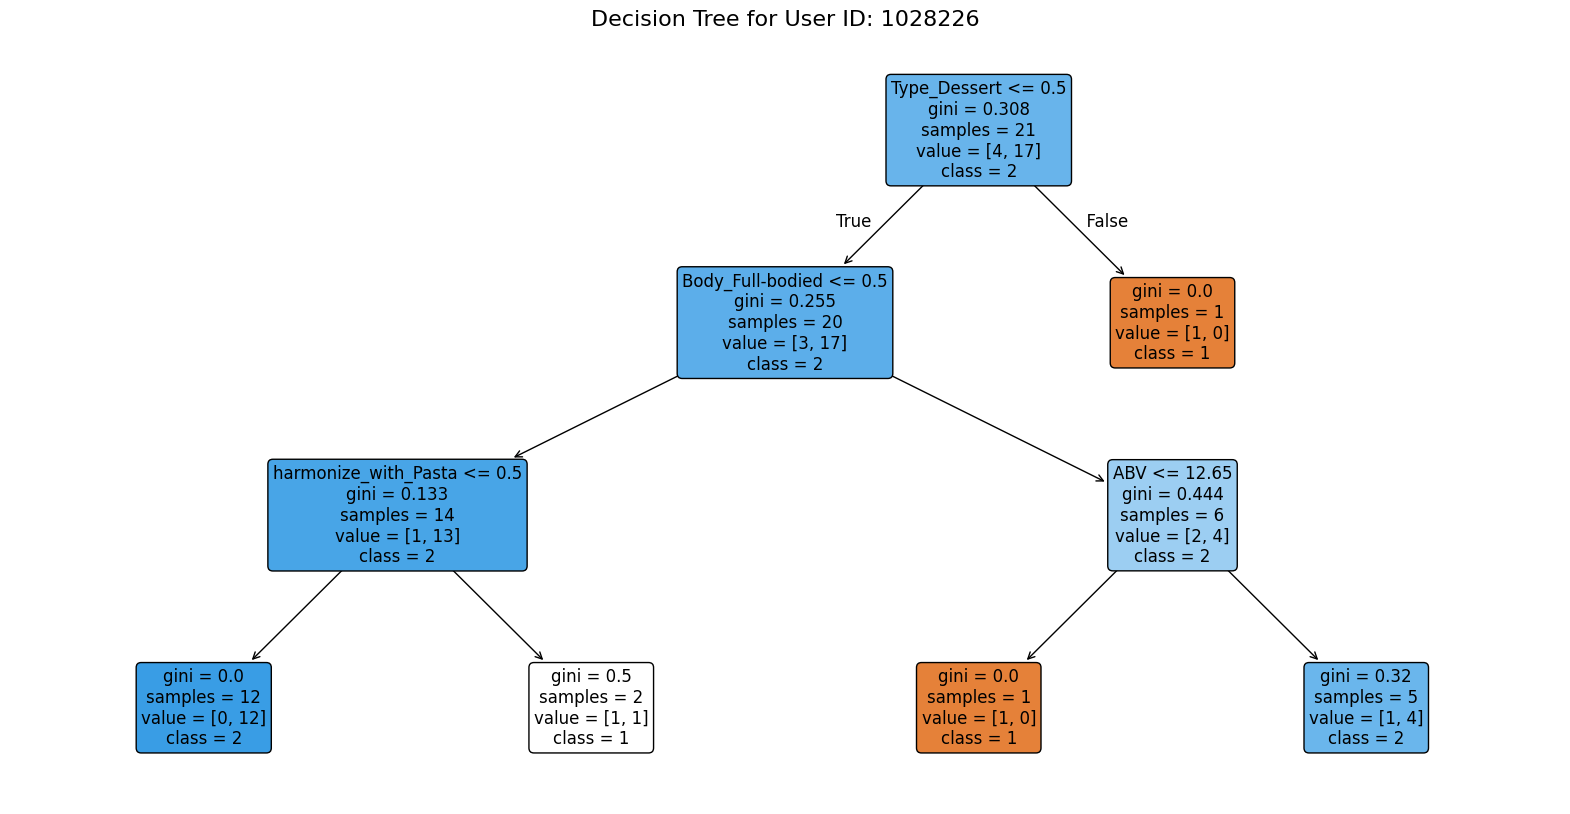

In [28]:
import matplotlib.pyplot as plt
from sklearn import tree
import random  # To select a random user

# Ensure reproducibility by setting a random seed (optional)
random.seed(42)  # You can choose any integer or remove this line for true randomness

# Get a list of all user IDs
all_users = list(user_models.keys())

# Select a random user
random_user = random.choice(all_users)

print(f"Selected User ID: {random_user}")

# Retrieve the selected user's model
selected_model = user_models[random_user]['model']

# Retrieve feature names
# Assuming that feature names are consistent across users and were used during training
# If not, you'll need to store feature names per user during training
# For demonstration, let's assume feature names are stored or accessible
# Replace 'X_train_columns' with your actual feature names list if different

# Example: If feature names are consistent and stored separately
# feature_names = X.columns.tolist()

# Alternatively, if feature names are stored within user_models (modify as per your storage)
# For this example, we'll assume they are consistent and stored as a separate list
# If not, please adjust accordingly.

# Replace the following line with your actual feature names
# Ensure X_train is defined in your notebook; otherwise, replace with your feature names list
feature_names = X_train.columns.tolist()  # Modify this line as needed

# Retrieve class names from the model
class_names = selected_model.classes_.astype(str)  # Convert to string for better readability

print(f"Number of Features: {len(feature_names)}")
print(f"Classes: {class_names}")

# Set the figure size for better readability
plt.figure(figsize=(20, 10))

# Plot the decision tree
tree.plot_tree(
    selected_model,
    feature_names=feature_names,          # Feature names used in training
    class_names=class_names,              # Class names (unique ratings)
    filled=True,                          # Fill nodes with colors
    rounded=True,                         # Rounded nodes
    fontsize=12,                          # Font size for text in the tree
    proportion=False,                     # Whether to show proportions
    impurity=True                         # Whether to show impurity measures
)

# Add a title to the plot
plt.title(f"Decision Tree for User ID: {random_user}", fontsize=16)

# Display the plot
plt.show()


In [23]:
# Here, we train one Decision Tree Classifier per user (Content Based Filtering)
# We split the User Ratings into Training and Testing Data (80-20 Stratified Split, to ensure the same distribution of ratings in both sets)

# IMPORTS
# Split the user ratings into training and testing data
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

user_models = {}

# Go through all the users
for user in ratings_df_slim['user'].unique():
    
    # Get all the ratings for the current user
    user_ratings = ratings_df_slim[ratings_df_slim['user'] == user]
    
    # Get the Subset of the Wines Dataset that the user has rated
    user_wines = wines_df_slim[wines_df_slim['item'].isin(user_ratings['item'])]

    # Merge user_ratings with user_wines on the 'item' column
    merged_data = pd.merge(user_ratings, user_wines, on='item', how='inner')
    
    # Specify which features we are NOT gonna use in X
    features_to_drop_for_X = ['RatingID', 'user', 'item', 'rating_label']
    
    # Get X and y
    X = merged_data.drop(columns=features_to_drop_for_X)
    y = merged_data['rating_label']

    # Split the data into training and testing sets (80-20 stratified split on the ratings)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create the Decision Tree Classifier
    clf = DecisionTreeClassifier(max_depth=3)
    
    # Fit the model
    clf.fit(X_train, y_train)
    
    # Evaluate the model
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    
    # Create a Dictionary with the User ID as the Key and the value another dictionary containing the Model, the Train Score and the Test Score
    user_models[user] = {
        'model': clf,
        'train_score': train_score,
        'test_score': test_score
    }

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.